In [1]:
import os
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from SiameseModelVer2 import Recognizer
from matplotlib import pyplot as plt

RAW_DATA_DIR = r'/work/martiks/PMData'
PARTICIPANTS = os.listdir(RAW_DATA_DIR) # Not including the .xlsx file
PARTICIPANTS = [p for p in PARTICIPANTS if ".xlsx" not in p]
MAX_WEEKS = 14
CHUNK_SIZE = {
    'heart_rate': 17280, #86400, #day=86400, week=604800
    'step': 10080
}

# Convert to taking inputs for these parameters.
DATA_TYPE = "heart_rate" # step, heart_rate

NUM_PARTICIPANTS = 16
assert (1 <= NUM_PARTICIPANTS <= 16), "Number of participants must be between 1-16"

NUM_WEEKS = 50 # NOTE: this is actually days now, not weeks
assert_msg = f"Number of weeks must be between 1-{MAX_WEEKS}"
#assert (1 <= NUM_WEEKS <= MAX_WEEKS), assert_msg

START_WEEK = 0 # input - 1
assert_msg = f"Must be <= {MAX_WEEKS - NUM_WEEKS}"
#assert (START_WEEK <= (MAX_WEEKS - NUM_WEEKS)), assert_msg

TEST_NUM_WEEKS = 20
assert_msg = f"Must be <= {MAX_WEEKS - (START_WEEK + NUM_WEEKS)}"
#assert (TEST_NUM_WEEKS <= (MAX_WEEKS - (START_WEEK + NUM_WEEKS))), assert_msg

TEST_START_WEEK = START_WEEK + NUM_WEEKS

print("======================================================TEST START======================================================")
print(f"Parameters used: num_participants={NUM_PARTICIPANTS}, num_weeks={NUM_WEEKS}, start_week={START_WEEK}, test_num_weeks={TEST_NUM_WEEKS}, test_start_week={TEST_START_WEEK}")

======================================================TEST START======================================================
Parameters used: num_participants=16, num_weeks=50, start_week=0, test_num_weeks=20, test_start_week=50


In [2]:
def read_file(maindir, p, file):
    path = f"{maindir}/{p}/fitbit/{file}"
    if ".json" in file:
        return pd.read_json(path)
    elif ".csv" in file:
        return pd.read_csv(path) # TODO: verify that pandas reads the PMData csv files properly
    else:
        raise TypeError("Unsupported file type!")


def clean_data_hr(df, start_date="2019-11-18 00:00:00", end_date="2020-02-23 23:59:59"):
    # Preserve datetime as index
    df['dateTime'] = pd.to_datetime(df['dateTime'])
    index = df['dateTime']
    
    # Convert dict-values to columns and set datetimes as index
    df = pd.DataFrame.from_dict(df.value.to_dict(), orient='index')
    df = df.set_index(index)

    # Check if start_date and end_date rows exist (create if not)
    if not start_date in df.index:
        stamp = pd.Timestamp(start_date)
        df.loc[stamp] = None
    if not end_date in df.index:
        stamp = pd.Timestamp(end_date)
        df.loc[stamp] = None
    
    # Sort chronologically using datetime-index
    df = df.sort_index()

    # Shave off incomplete weeks at start/end
    df = df.loc[start_date:end_date] # Adjust dates as necessary

    # Fill in missing rows to make data set consistent (secondly)
    df = df.resample('1s').first()

    # Interpolate, round off and cast to int
    df['bpm'] = df.bpm.interpolate(method='linear', limit_direction='both').round(0).astype(np.int32)
    
    # Resample back to 5-second frequency
    df = df.resample('5s').first()

    # Add day of the week features
    df = df.reset_index()
    df['weekday'] = df['dateTime'].dt.dayofweek
    df['mon'] = df['weekday'].apply(lambda x: 1 if (x==0) else 0)
    df['tue'] = df['weekday'].apply(lambda x: 1 if (x==1) else 0)
    df['wed'] = df['weekday'].apply(lambda x: 1 if (x==2) else 0)
    df['thu'] = df['weekday'].apply(lambda x: 1 if (x==3) else 0)
    df['fri'] = df['weekday'].apply(lambda x: 1 if (x==4) else 0)
    df['sat'] = df['weekday'].apply(lambda x: 1 if (x==5) else 0)
    df['sun'] = df['weekday'].apply(lambda x: 1 if (x==6) else 0)

    # Remove unwanted columns
    del df['dateTime']
    del df['confidence']
    del df['weekday']
    
    return df

In [3]:
def prepare_chunks(datasets, start_week=0, weeks=5, no_ID=False):
    # List with participant name and corresponding week-chunks
    # [('p01', chunks), ('p02', chunks), ...]
    chunks = []
    start_ind = start_week * CHUNK_SIZE[DATA_TYPE] # Finds index corresponding to monday 00:00:00 of start_week
    for p in datasets:
        for i in range(weeks): # weeks mon-sun
            from_ind = start_ind + (CHUNK_SIZE[DATA_TYPE] * i)
            to_ind = from_ind + (CHUNK_SIZE[DATA_TYPE] - 1)
            chunk = p[1].loc[from_ind:to_ind]
            chunk = np.array(chunk)
            if no_ID:
                chunks.append(chunk)
            else:
                chunks.append((p[0], chunk))
    return chunks


def remove_ID(dataset):
    # Remove ID
    for i in range(len(dataset)):
        dataset[i] = dataset[i][1]

In [4]:
# BALANCED VERSION
def balanced_sets(chunks):
    input_1 = []
    input_2 = []
    # Match all chunks (balanced 50/50 split)
    for i in range(len(chunks)):
        same = []
        not_same = []
        for j in range(len(chunks)):
            if chunks[j][0] == chunks[i][0]:
                same.append(chunks[j])
            else:
                not_same.append(chunks[j])
        random.shuffle(same)
        random.shuffle(not_same)
        not_same = not_same[:len(same)] # match lengths for balance
        to_add = same + not_same
        random.shuffle(to_add)
        input_2.extend(to_add)
        for x in range(len(to_add)):
            input_1.append(chunks[i])
    
    return input_1, input_2

In [5]:
# GENERATE LABELS AND REMOVE ID
def generate_labels(input_1, input_2):
    """
    WARNING: Will modify inputs.
    """
    labels = []
    for i in range(len(input_1)):
        # Check if they have the same ID
        p1 = input_1[i][0]
        p2 = input_2[i][0]
        if p1 == p2:
            labels.append(1)
        else:
            labels.append(0)
    remove_ID(input_1)
    remove_ID(input_2)

    return labels

In [6]:
def prepare_inputs(start_index, length):
    chunks = prepare_chunks(datasets, start_week=start_index, weeks=length)
    x1, x2 = balanced_sets(chunks)
    y = generate_labels(x1, x2)
    X1 = np.array(x1)
    X2 = np.array(x2)
    Y = np.array(y)
    
    return X1, X2, Y

In [7]:
# DATA PROCESSING

datasets = []
for p in PARTICIPANTS[:NUM_PARTICIPANTS]:
    pdata = read_file(RAW_DATA_DIR, p, "heart_rate.json")
    d = clean_data_hr(pdata)
    tup = (p, d)
    datasets.append(tup)

In [8]:
X1, X2, Y = prepare_inputs(START_WEEK, NUM_WEEKS)

chunk_len = len(X1)
train_len = int(chunk_len * 0.7)
X1_train = X1[:train_len]
X1_val = X1[train_len:]
X2_train = X2[:train_len]
X2_val = X2[train_len:]
Y_train = Y[:train_len]
Y_val = Y[train_len:]

In [9]:
# MODEL TRAINING

recognizer = Recognizer()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

checkpoint_filepath_loss = '/work/martiks/saved_model/loss'
save_checkpoint_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_loss,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True
)

checkpoint_filepath_val_loss = '/work/martiks/saved_model/val_loss'
save_checkpoint_val_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_val_loss,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

parameters = {
    'batch_size' : 16 ,
    'epochs' : 5000 , # 5000 if callback is implemented
    'callbacks' : [early_stop, save_checkpoint_loss, save_checkpoint_val_loss] ,
    'val_data' : ([X1_val, X2_val], Y_val) #None
}

history = recognizer.fit([X1_train, X2_train], Y_train, hyperparameters=parameters)

Epoch 1/5000
3500/3500 [==============================] - ETA: 0s - loss: 2.5986 - accuracy: 0.7654WARNING:tensorflow:From /work/martiks/tfpy/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /work/martiks/saved_model/loss/assets
INFO:tensorflow:Assets written to: /work/martiks/saved_model/val_loss/assets
3500/3500 [==============================] - 432s 123ms/step - loss: 2.5986 - accuracy: 0.7654 - val_loss: 0.7196 - val_accuracy: 0.6435
Epoch 2/5000
3500/3500 [==============================] - 397s 113ms/step - loss: 0.4671 - accuracy: 0.8414 - val_loss: 0.7997 - val_a

In [10]:
# TESTING

def calc_scores_new(model, data_chunks, test_chunks): # is actually the old version now
    random.shuffle(data_chunks)
    random.shuffle(test_chunks)
    data_chunks = data_chunks[:len(test_chunks)] # match lengths
    truths = []
    for x, y in zip(data_chunks, test_chunks):
        if x[0] == y[0]:
            truths.append(1)
        else:
            truths.append(0)
    
    remove_ID(data_chunks)
    remove_ID(test_chunks)

    X = np.array(data_chunks)
    Y = np.array(test_chunks)

    scores = model.predict([X, Y])

    results = {
        'scores': scores,
        'truths': truths
    }

    return results

In [11]:
def print_scores_new(scores, truths):
    for i in range(len(scores)):
        print(f"Test {i} ground truth: {truths[i]}, predicted score: {scores[i]}")

In [12]:
def print_scores_avg(scores, truths):
    passed = 0
    for i in range(len(scores)):
        truth = truths[i]
        score = np.average(scores[i])
        test = "FAILED"
        if (truth == 0) and (0 <= score < 0.5):
            test = "PASSED"
            passed += 1
        elif (truth == 1) and (0.5 <= score <= 1):
            test = "PASSED"
            passed += 1
        print(f"Test {i} ground truth: {truth}, predicted score: {score}, test: {test}")
    print(f"Passed {passed} of {len(scores)} tests.")

In [13]:
def print_scores(scores, truths):
    passed = 0
    for i in range(len(scores)):
        truth = truths[i]
        score = scores[i]
        test = "FAILED"
        if (truth == 0) and (0 <= score < 0.5):
            test = "PASSED"
            passed += 1
        elif (truth == 1) and (0.5 <= score <= 1):
            test = "PASSED"
            passed += 1
        print(f"Test {i} ground truth: {truth}, predicted score: {score}, test: {test}")
    print(f"Passed {passed} of {len(scores)} tests.")

In [14]:
# Load saved best model
loaded_recognizer = tf.keras.models.load_model('/work/martiks/saved_model/val_loss')

In [30]:
# BALANCED TEST
t1, t2, truths = prepare_inputs(TEST_START_WEEK, TEST_NUM_WEEKS)
scores = loaded_recognizer.predict([t1, t2])

In [31]:
print_scores(scores, truths)

Test 0 ground truth: 0, predicted score: [0.56099397], test: FAILED
Test 1 ground truth: 1, predicted score: [0.70526284], test: PASSED
Test 2 ground truth: 1, predicted score: [0.75138986], test: PASSED
Test 3 ground truth: 1, predicted score: [0.73889464], test: PASSED
Test 4 ground truth: 1, predicted score: [0.68351275], test: PASSED
Test 5 ground truth: 1, predicted score: [0.7901105], test: PASSED
Test 6 ground truth: 0, predicted score: [0.21148576], test: PASSED
Test 7 ground truth: 0, predicted score: [0.11973147], test: PASSED
Test 8 ground truth: 1, predicted score: [0.7123024], test: PASSED
Test 9 ground truth: 0, predicted score: [0.45046854], test: PASSED
Test 10 ground truth: 1, predicted score: [0.745988], test: PASSED
Test 11 ground truth: 1, predicted score: [0.74644643], test: PASSED
Test 12 ground truth: 0, predicted score: [0.74564624], test: FAILED
Test 13 ground truth: 0, predicted score: [0.16500576], test: PASSED
Test 14 ground truth: 1, predicted score: [0.669

=======================================================TEST END=======================================================


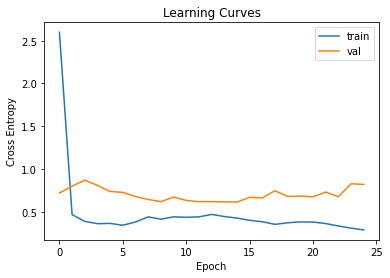

In [17]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.savefig('learning_curve.png')

print("=======================================================TEST END=======================================================")

In [ ]:
!tar chvfz notebook.tar.gz *

hr_version.py
jupyter.sbatch
learning_curve.png
old_outputs/
old_outputs/slurm-89871.out
old_outputs/slurm-91069.out
old_outputs/.ipynb_checkpoints/
old_outputs/.ipynb_checkpoints/slurm-91069-checkpoint.out
old_outputs/.ipynb_checkpoints/slurm-95611-checkpoint.out
old_outputs/.ipynb_checkpoints/slurm-96024-checkpoint.out
old_outputs/.ipynb_checkpoints/slurm-96025-checkpoint.out
old_outputs/.ipynb_checkpoints/slurm-96078-checkpoint.out
old_outputs/slurm-91071.out
old_outputs/slurm-91237.out
old_outputs/slurm-91549.out
old_outputs/slurm-91695.out
old_outputs/slurm-94035.out
old_outputs/slurm-94063.out
old_outputs/slurm-95558.out
old_outputs/slurm-95581.out
old_outputs/slurm-95589.out
old_outputs/slurm-95611.out
old_outputs/slurm-95630.out
old_outputs/slurm-96024.out
old_outputs/slurm-96025.out
old_outputs/slurm-96078.out
old_saved_models/
old_saved_models/91695/
old_saved_models/91695/assets/
old_saved_models/91695/saved_model.pb
old_saved_models/91695/variables/
old_saved_models/91695/v